In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
def LoadBFData(filename):
    data = pd.read_csv(filename, header=None, delimiter=" ")
    dataval = data.values
    if(dataval[0,0]==0.05):
        dataval=np.delete(dataval,0,0)
        print('deleting rapidity==0.05 row from',filename)
    dy = dataval[:,0]
    if(math.isnan(dataval[0,-1])):
        #print("last value (0,-1) in",filename,"is nan, removing last column")
        bf = dataval[:,1:-1]
    else:
        bf = dataval[:,1:]
    return dy, bf

def LoadBFDataAll(filenames):
    dy, BF = LoadBFData(filenames[0])
    for i in range(1,len(filenames)):
        dy, bf = LoadBFData(filenames[i])
        BF = np.concatenate((BF,bf),axis=0)
    return dy, BF

def LoadData(filename):
    datafile = pd.read_csv(filename, header=None, delimiter=" ")
    dataval = datafile.values
    if(math.isnan(dataval[0,-1])):
        #print("last value (0,-1) in",filename,"is nan, removing last column")
        dataval = dataval[:,:-1]
    return dataval

def normalize_features(X_train, X_test):
    from sklearn.preprocessing import StandardScaler #import libaray
    scaler = StandardScaler() # call an object function
    scaler.fit(X_train) # calculate mean, std in X_train
    X_train_norm = scaler.transform(X_train) # apply normalization on X_train
    X_test_norm = scaler.transform(X_test) # we use the same normalization on X_test
    return X_train_norm, X_test_norm

def NormFeatures(X_train__, X_test__,scale__):
    maxv__ = np.amax(X_train__,0)
    minv__ = np.amin(X_train__,0)
    X_train_norm__ = np.copy(X_train__)
    X_test_norm__ = np.copy(X_test__)
    for i in range(X_train_norm__.shape[1]):
        if(maxv__[i] != minv__[i]):
            X_train_norm__[:,i] = scale__*(X_train__[:,i]-minv__[i])/(maxv__[i]-minv__[i])
            X_test_norm__[:,i] = scale__*(X_test__[:,i]-minv__[i])/(maxv__[i]-minv__[i])
        else:
            X_train_norm__[:,i] = scale__*(X_train__[:,i]-minv__[i])
            X_test_norm__[:,i] = scale__*(X_test__[:,i]-minv__[i])
    return X_train_norm__, X_test_norm__, maxv__, minv__

def RestFeatures(X_train_norm__, X_test_norm__, maxv__, minv__,scale__):
    X_train__ = np.copy(X_train_norm__)
    X_test__ = np.copy(X_test_norm__)
    for i in range(X_train_norm__.shape[1]):
        if(maxv__[i] != minv__[i]):
            X_train__[:,i] = X_train_norm__[:,i]/scale__*(maxv__[i]-minv__[i])+minv__[i]
            X_test__[:,i] = X_test_norm__[:,i]/scale__*(maxv__[i]-minv__[i])+minv__[i]
        else:
            X_train__[:,i] = X_train_norm__[:,i]/scale__+minv__[i]
            X_test__[:,i] = X_test_norm__[:,i]/scale__+minv__[i]
    return X_train__, X_test__
    

In [3]:
folder="data"
pipi_modelname = folder+"/I211_J211.dat"
ppbar_modelname = folder+"/I2212_J2212.dat"
pk_modelname = folder+"/I321_J2212.dat"
kk_modelname = folder+"/I321_J321.dat"

model_filenames = [pipi_modelname,ppbar_modelname,pk_modelname,kk_modelname]
dy, model = LoadBFDataAll(model_filenames)
model = model.T
parameters = LoadData(folder+"/moments_parameters.dat")
moments = LoadData(folder+"/modelmoments.dat").T
pca = LoadData(folder+"/modelz.dat")

folder="data"
pipi_expname = folder+"/star_pipi.dat"
ppbar_expname = folder+"/star_ppbar.dat"
pk_expname = folder+"/star_pK.dat"
kk_expname = folder+"/star_KK.dat"
exp_filenames = [pipi_expname,ppbar_expname,pk_expname,kk_expname]
expdy, exp = LoadBFDataAll(exp_filenames)
expdy = np.delete(expdy,0,0)
exp = exp.T
exp = exp[0,:]
print(dy.shape,model.shape,expdy.shape,exp.shape,parameters.shape,moments.shape,pca.shape)

deleting rapidity==0.05 row from data/star_pipi.dat
deleting rapidity==0.05 row from data/star_ppbar.dat
deleting rapidity==0.05 row from data/star_pK.dat
deleting rapidity==0.05 row from data/star_KK.dat
(17,) (200, 68) (24,) (100,) (200, 12) (200, 12) (200, 12)


In [4]:
from random import *
import math

def LogLikeLihood(Y,y):
    return -0.5*np.sum((Y-y)*(Y-y))

class MCMC:
    def __init__(self,MLA__,X__,y__,target__,LLH__,step__,xmaxv__,xminv__):
        self.MLA__ = MLA__
        self.X__ = X__
        self.y__ = y__
        self.target__ = target__
        self.LLH__ = LLH__
        print("target:",self.target__)
        self.Z__ = np.zeros(2)
        self.Z__[0] = 1.5708
        self.Z__[1] = -1.04706 
        
        self.MLA__.fit(self.X__,self.y__)
        self.position__ = np.random.rand(self.X__.shape[1])
        self.positiony__ = self.MLA__.predict(self.position__.reshape(1,-1))
        self.llh__ = self.LLH__(self.target__,self.positiony__)
        self.maxLLH__ = self.llh__

        self.step_size__ = np.zeros(self.X__.shape[1]) + step__
        self.xmaxv__ = xmaxv__
        self.xminv__ = xminv__

    def step__(self):
        nmax__ = 1
        ab__ = 4
        testx__ = self.position__ + 2.0*(np.random.rand(len(self.position__)) - 0.5)*self.step_size__
        if(np.any(testx__ < 0) or np.any(testx__ > 1)):
            #print("out of range")
            return 0

        TestX__ = testx__*(self.xmaxv__ - self.xminv__) + self.xminv__
        for j__ in range(ab__):
            TestX__[j__*(nmax__+2)+1] = 1.0/TestX__[j__*(nmax__+2)]
            for k__ in range(1,nmax__+1):
                TestX__[j__*(nmax__+2)+1] -= TestX__[j__*(nmax__+2)+k__+1]*self.Z__[k__]
            TestX__[j__*(nmax__+2)+1] /= self.Z__[0]
        testx__ = (TestX__ - self.xminv__)/(self.xmaxv__ - self.xminv__)
        if(np.any(testx__ < 0) or np.any(testx__ > 1)):
            #print("out of range")
            return 0

        testy__ = self.MLA__.predict(testx__.reshape(1,-1))
        llh__ = self.LLH__(testy__,self.target__)
        if(llh__ > self.maxLLH__):
            self.maxLLH__ = llh__
            self.llh__ = llh__
            self.position__ = testx__
            self.positiony__ = testy__
            print("  MaxLLH:",self.maxLLH__)
            return 1
        if(llh__ > self.llh__):
            self.llh__ = llh__
            self.position__ = testx__
            self.positiony__ = testy__
            return 1
        else:
            rand__ = random()
            lnrand__ = math.log(rand__)
            if(lnrand__ > (llh__ - self.llh__)):
                return 0
            else:
                self.llh__ = llh__
                self.position__ = testx__
                self.positiony__ = testy__
                return 1
     
    def run__(self,count__):
        self.acct__ = 0
        self.trace__ = np.zeros((int(count__*4/25),self.X__.shape[1]))
        j__=0
        for i__ in range(count__):
            self.acct__ += self.step__()
            if((i__+1)%(count__/10)==0):
                print((i__+1)/count__*100,"% complete")
                print("  acct",self.acct__/(i__+1)*100,"%")
                print("  LLH",self.maxLLH__)
            if(i__>(count__/5) and i__%5==0):
                self.trace__[j__] = self.position__
                j__+=1



In [30]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   

def ReconstructTarget(X,y,target):
    X_train = np.append(X[:target,:],X[target+1:,:],axis=0)
    y_train = np.append(y[:target,:],y[target+1:,:],axis=0)

    X_test = X[target,:].reshape(1,-1)
    y_test = y[target,:].reshape(1,-1)

    xscale=1.0
    X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)

    layer=100
    print("Nodes in NN layer",layer)
    NN = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \
                  #random_sate=1, \
                 )

    NN.fit(X_train_norm,y_train)
    y_pred = NN.predict(X_test_norm)
    perf = NN.score(X_test_norm,y_test)

    print("NN performance",perf)

    print("Red==199 Model Runs\nBlue==",target,"\nBlack==NN attempt to create BLUE from RED")
    plt.figure(2)
    plt.subplot(221)
    plt.plot(dy,y_train[:,:17].T,'red')
    plt.plot(dy,y_test[:,:17].T,'black')
    plt.plot(dy,y_pred[:,:17].T,'blue')
    
    plt.subplot(222)
    plt.plot(dy,y_train[:,17:34].T,'red')
    plt.plot(dy,y_test[:,17:34].T,'black')
    plt.plot(dy,y_pred[:,17:34].T,'blue')
    
    plt.subplot(223)
    plt.plot(dy,y_train[:,34:51].T,'red')
    plt.plot(dy,y_test[:,34:51].T,'black')
    plt.plot(dy,y_pred[:,34:51].T,'blue')
    
    plt.subplot(224)
    plt.plot(dy,y_train[:,51:68].T,'red')
    plt.plot(dy,y_test[:,51:68].T,'black')
    plt.plot(dy,y_pred[:,51:68].T,'blue')
    plt.show()

    
    '''
    figfolder = "figs"
    fig, ax = plt.subplots()
    plt.ylabel('PiPi')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,:17].T,'red')
    plt.plot(dy,y_test[:,:17].T,'black')
    plt.plot(dy,y_pred[:,:17].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/pipi_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('PPbar')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,17:34].T,'red')
    plt.plot(dy,y_test[:,17:34].T,'black')
    plt.plot(dy,y_pred[:,17:34].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/ppbar_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('PK')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,34:51].T,'red')
    plt.plot(dy,y_test[:,34:51].T,'black')
    plt.plot(dy,y_pred[:,34:51].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/pk_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('KK')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,51:68].T,'red')
    plt.plot(dy,y_test[:,51:68].T,'black')
    plt.plot(dy,y_pred[:,51:68].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/kk_nn.pdf")
    '''

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 0 
Black==NN attempt to create BLUE from RED


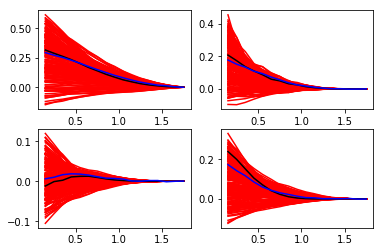

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 1 
Black==NN attempt to create BLUE from RED


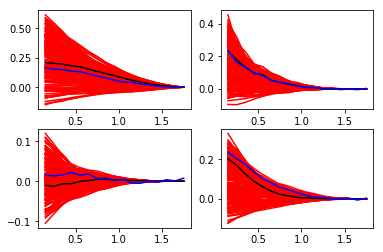

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 2 
Black==NN attempt to create BLUE from RED


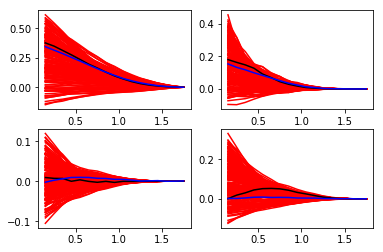

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 3 
Black==NN attempt to create BLUE from RED


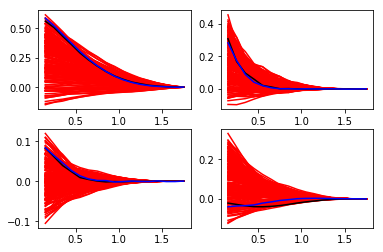

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 4 
Black==NN attempt to create BLUE from RED


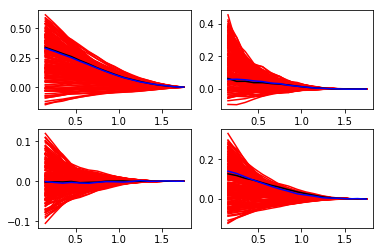

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 5 
Black==NN attempt to create BLUE from RED


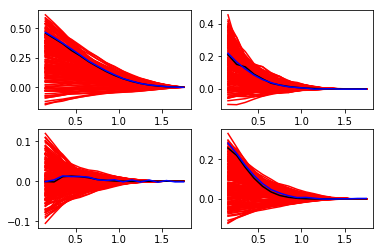

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 6 
Black==NN attempt to create BLUE from RED


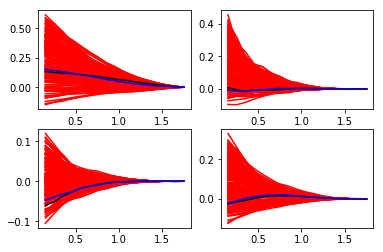

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 7 
Black==NN attempt to create BLUE from RED


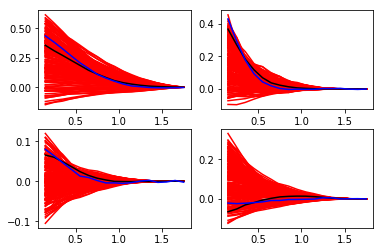

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 8 
Black==NN attempt to create BLUE from RED


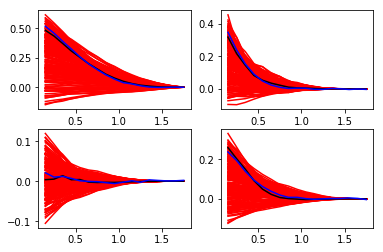

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 9 
Black==NN attempt to create BLUE from RED


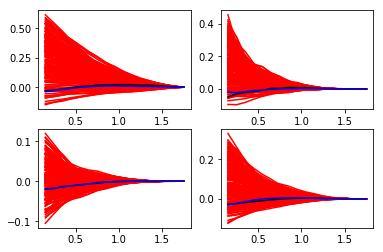

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 10 
Black==NN attempt to create BLUE from RED


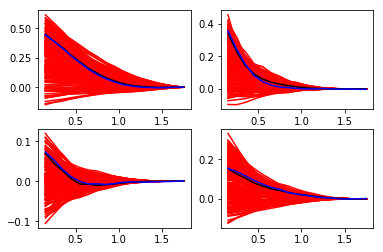

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 11 
Black==NN attempt to create BLUE from RED


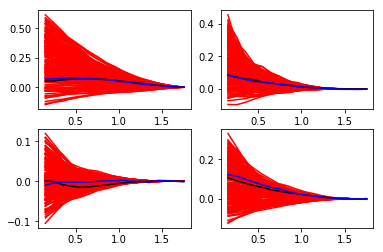

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 12 
Black==NN attempt to create BLUE from RED


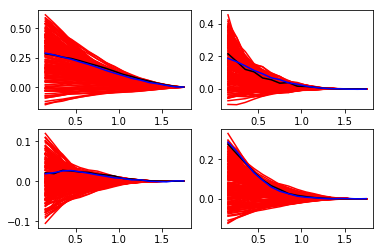

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 13 
Black==NN attempt to create BLUE from RED


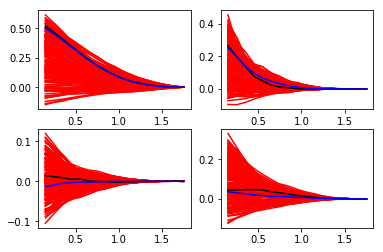

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 14 
Black==NN attempt to create BLUE from RED


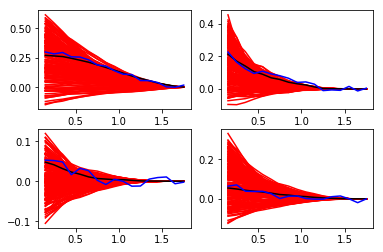

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 15 
Black==NN attempt to create BLUE from RED


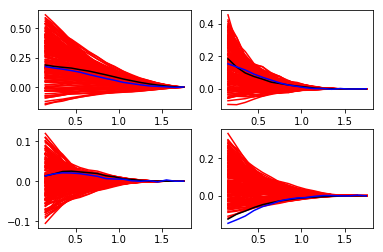

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 16 
Black==NN attempt to create BLUE from RED


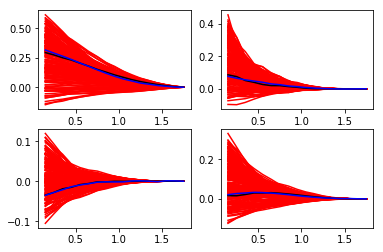

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 17 
Black==NN attempt to create BLUE from RED


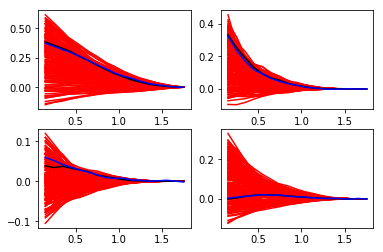

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 18 
Black==NN attempt to create BLUE from RED


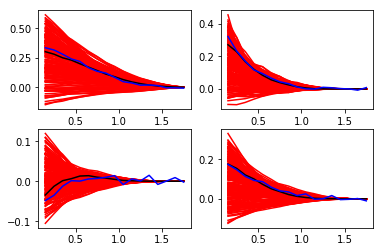

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 19 
Black==NN attempt to create BLUE from RED


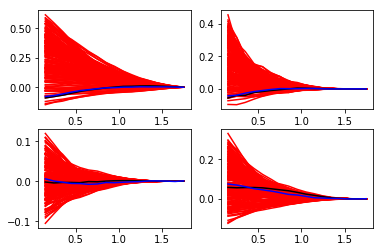

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 20 
Black==NN attempt to create BLUE from RED


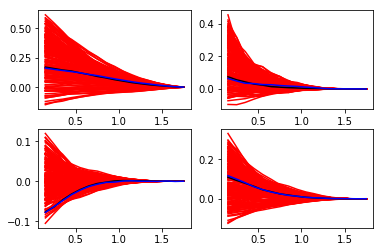

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 21 
Black==NN attempt to create BLUE from RED


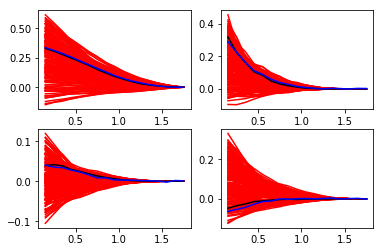

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 22 
Black==NN attempt to create BLUE from RED


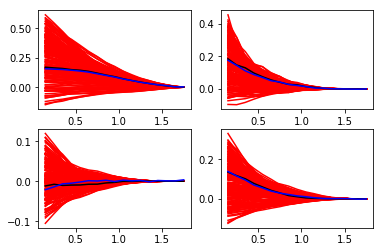

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 23 
Black==NN attempt to create BLUE from RED


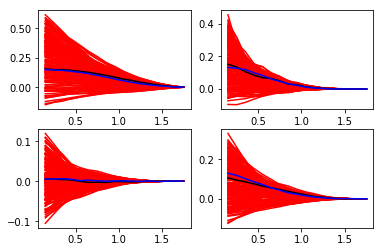

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 24 
Black==NN attempt to create BLUE from RED


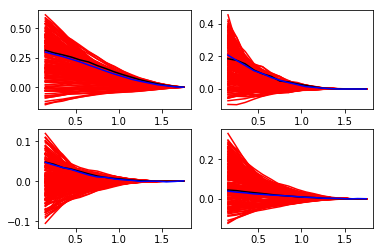

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 25 
Black==NN attempt to create BLUE from RED


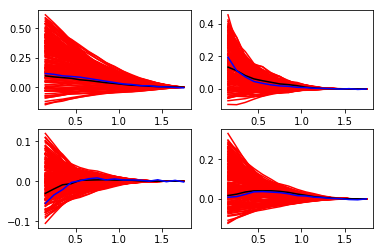

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 26 
Black==NN attempt to create BLUE from RED


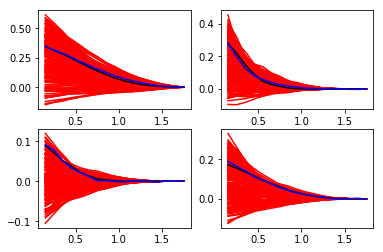

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 27 
Black==NN attempt to create BLUE from RED


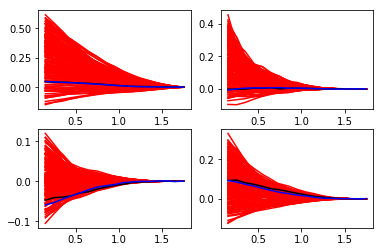

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 28 
Black==NN attempt to create BLUE from RED


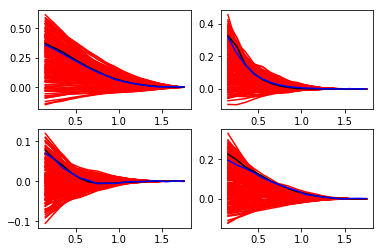

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 29 
Black==NN attempt to create BLUE from RED


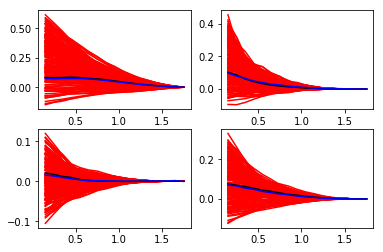

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 30 
Black==NN attempt to create BLUE from RED


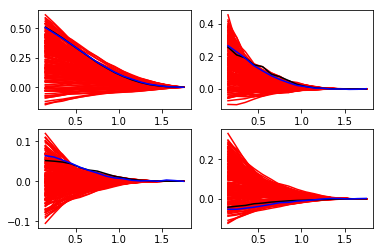

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 31 
Black==NN attempt to create BLUE from RED


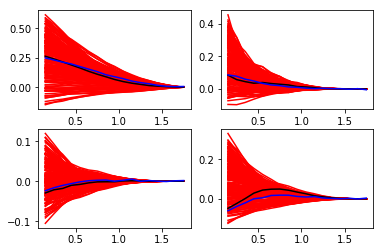

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 32 
Black==NN attempt to create BLUE from RED


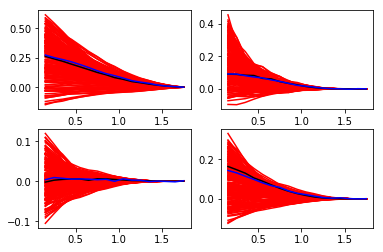

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 33 
Black==NN attempt to create BLUE from RED


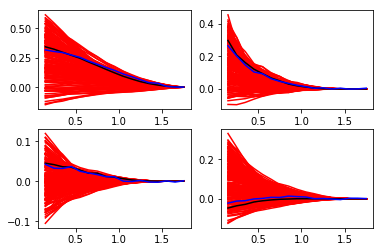

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 34 
Black==NN attempt to create BLUE from RED


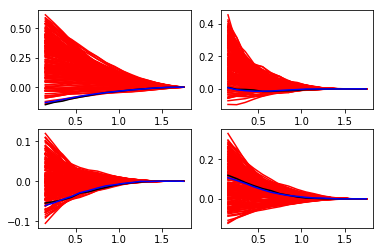

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 35 
Black==NN attempt to create BLUE from RED


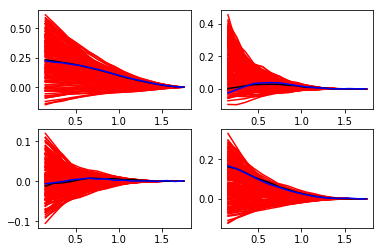

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 36 
Black==NN attempt to create BLUE from RED


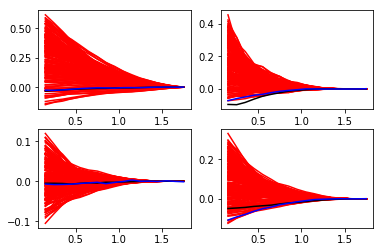

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 37 
Black==NN attempt to create BLUE from RED


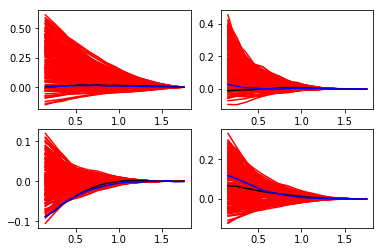

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 38 
Black==NN attempt to create BLUE from RED


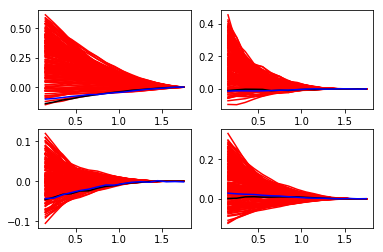

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 39 
Black==NN attempt to create BLUE from RED


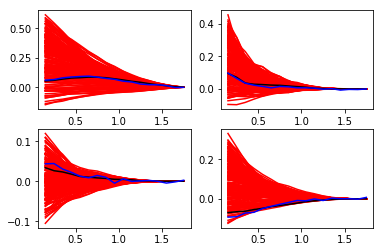

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 40 
Black==NN attempt to create BLUE from RED


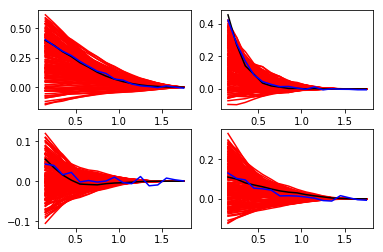

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 41 
Black==NN attempt to create BLUE from RED


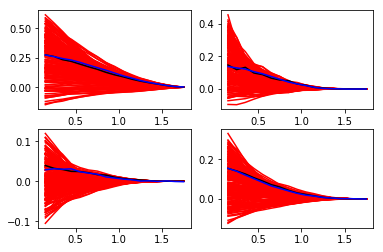

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 42 
Black==NN attempt to create BLUE from RED


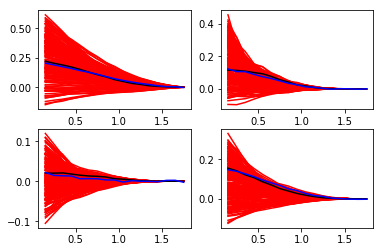

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 43 
Black==NN attempt to create BLUE from RED


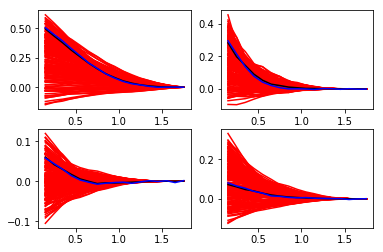

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 44 
Black==NN attempt to create BLUE from RED


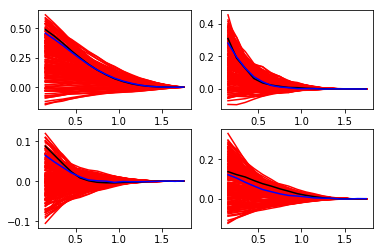

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 45 
Black==NN attempt to create BLUE from RED


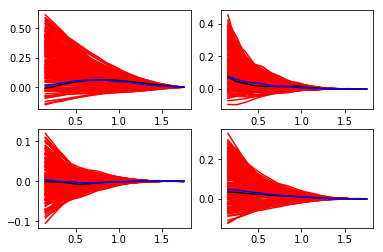

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 46 
Black==NN attempt to create BLUE from RED


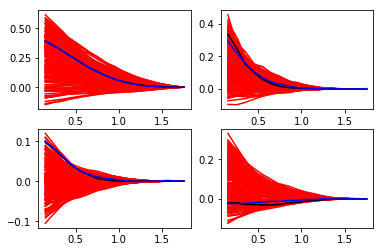

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 47 
Black==NN attempt to create BLUE from RED


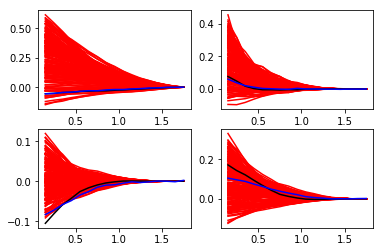

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 48 
Black==NN attempt to create BLUE from RED


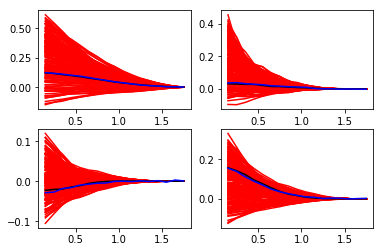

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 49 
Black==NN attempt to create BLUE from RED


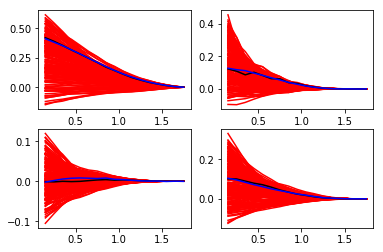

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 50 
Black==NN attempt to create BLUE from RED


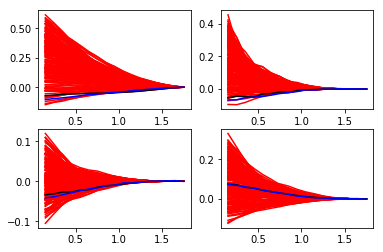

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 51 
Black==NN attempt to create BLUE from RED


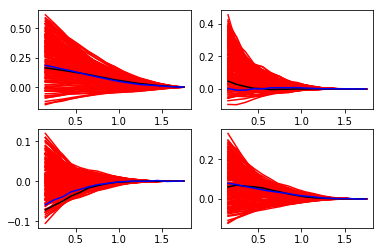

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 52 
Black==NN attempt to create BLUE from RED


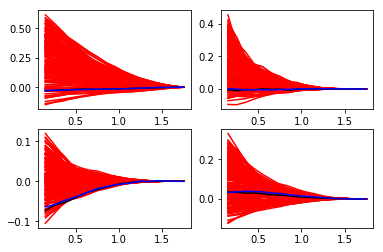

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 53 
Black==NN attempt to create BLUE from RED


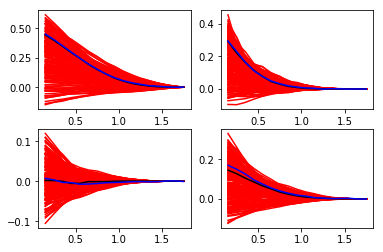

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 54 
Black==NN attempt to create BLUE from RED


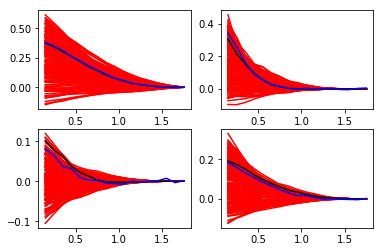

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 55 
Black==NN attempt to create BLUE from RED


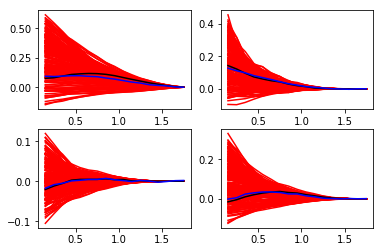

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 56 
Black==NN attempt to create BLUE from RED


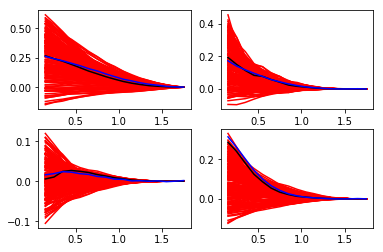

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 57 
Black==NN attempt to create BLUE from RED


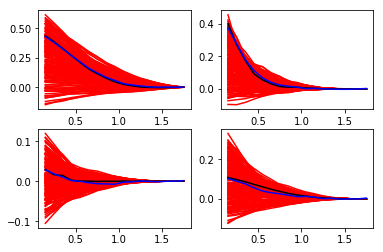

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 58 
Black==NN attempt to create BLUE from RED


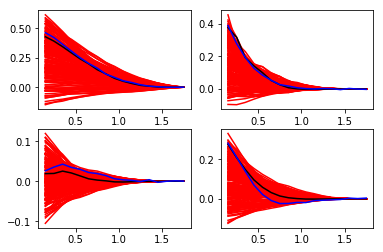

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 59 
Black==NN attempt to create BLUE from RED


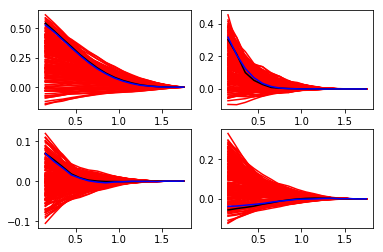

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 60 
Black==NN attempt to create BLUE from RED


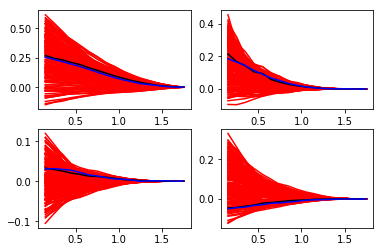

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 61 
Black==NN attempt to create BLUE from RED


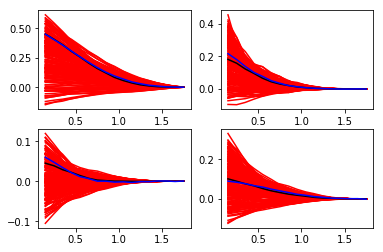

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 62 
Black==NN attempt to create BLUE from RED


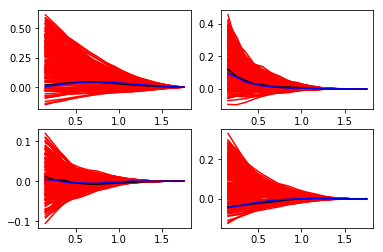

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 63 
Black==NN attempt to create BLUE from RED


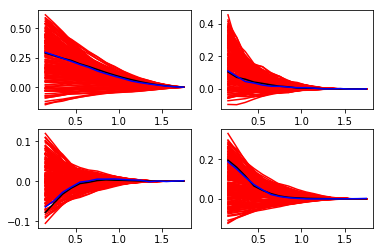

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 64 
Black==NN attempt to create BLUE from RED


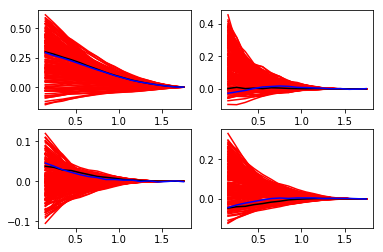

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 65 
Black==NN attempt to create BLUE from RED


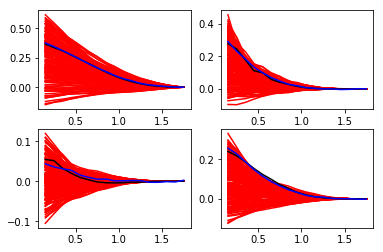

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 66 
Black==NN attempt to create BLUE from RED


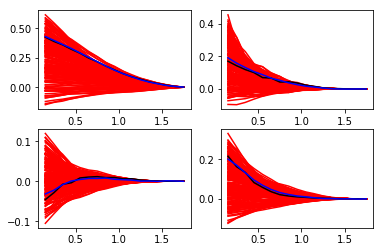

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 67 
Black==NN attempt to create BLUE from RED


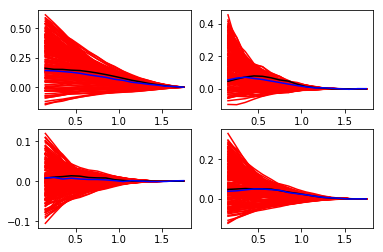

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 68 
Black==NN attempt to create BLUE from RED


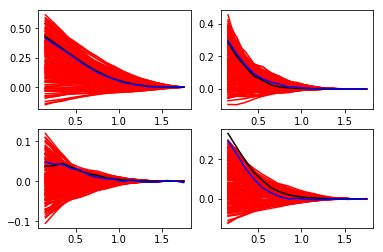

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 69 
Black==NN attempt to create BLUE from RED


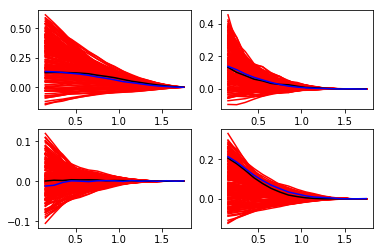

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 70 
Black==NN attempt to create BLUE from RED


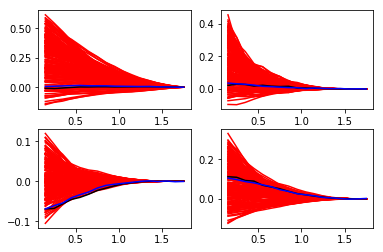

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 71 
Black==NN attempt to create BLUE from RED


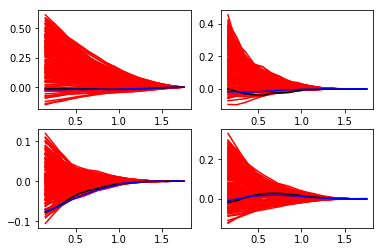

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 72 
Black==NN attempt to create BLUE from RED


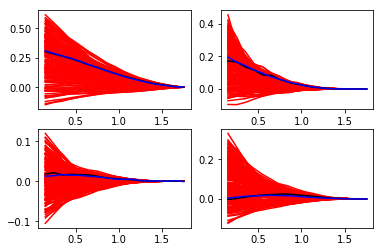

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 73 
Black==NN attempt to create BLUE from RED


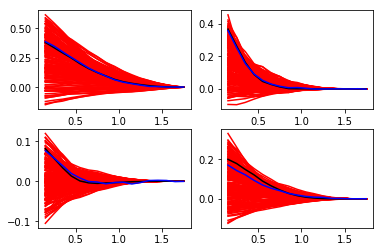

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 74 
Black==NN attempt to create BLUE from RED


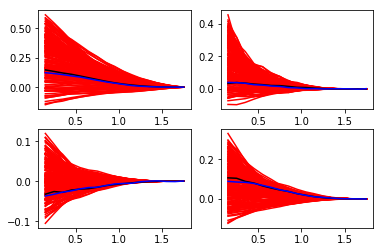

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 75 
Black==NN attempt to create BLUE from RED


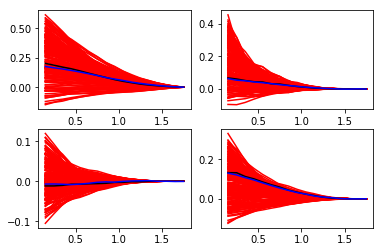

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 76 
Black==NN attempt to create BLUE from RED


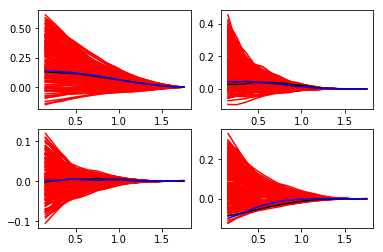

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 77 
Black==NN attempt to create BLUE from RED


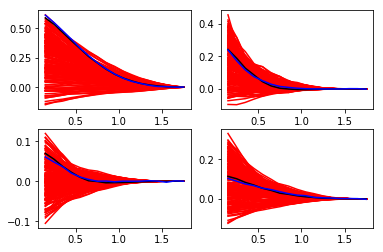

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 78 
Black==NN attempt to create BLUE from RED


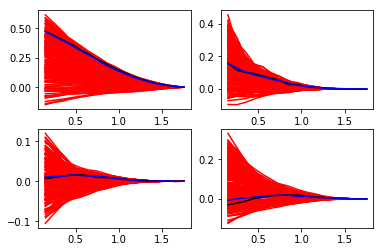

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 79 
Black==NN attempt to create BLUE from RED


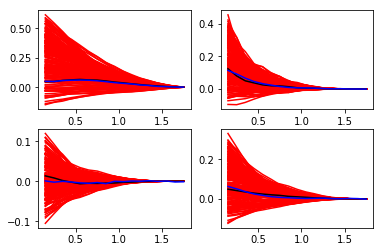

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 80 
Black==NN attempt to create BLUE from RED


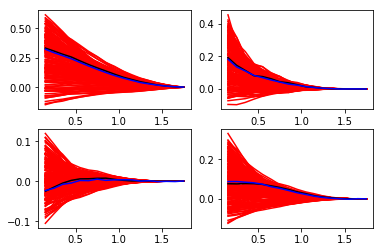

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 81 
Black==NN attempt to create BLUE from RED


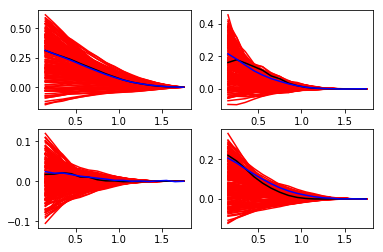

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 82 
Black==NN attempt to create BLUE from RED


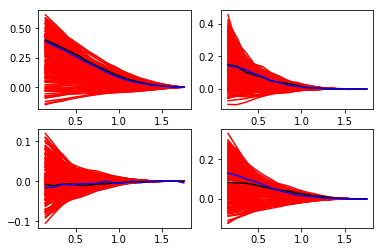

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 83 
Black==NN attempt to create BLUE from RED


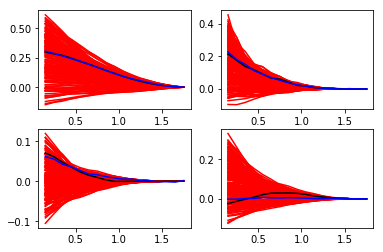

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 84 
Black==NN attempt to create BLUE from RED


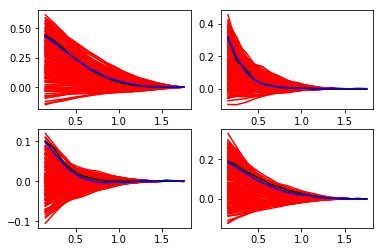

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 85 
Black==NN attempt to create BLUE from RED


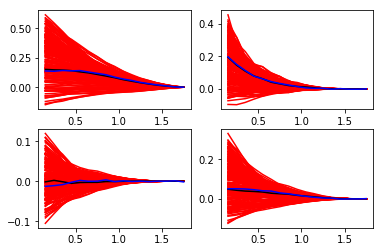

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 86 
Black==NN attempt to create BLUE from RED


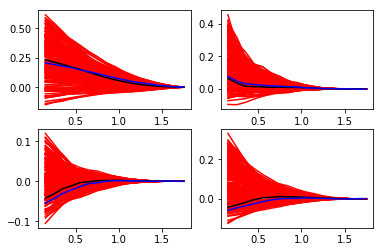

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 87 
Black==NN attempt to create BLUE from RED


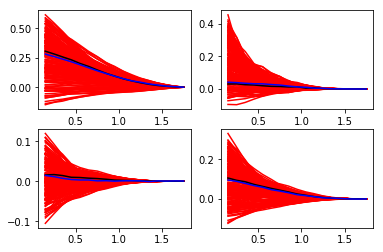

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 88 
Black==NN attempt to create BLUE from RED


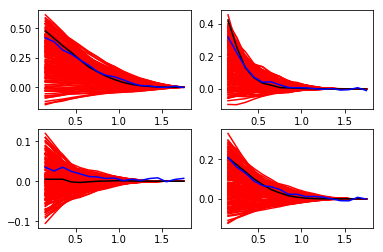

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 89 
Black==NN attempt to create BLUE from RED


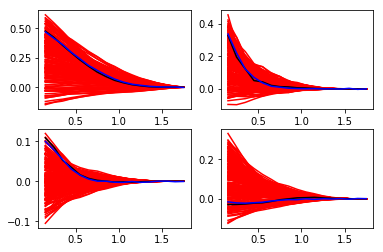

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 90 
Black==NN attempt to create BLUE from RED


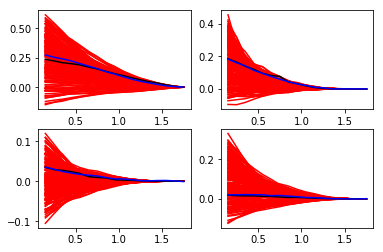

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 91 
Black==NN attempt to create BLUE from RED


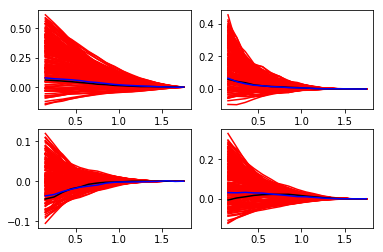

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 92 
Black==NN attempt to create BLUE from RED


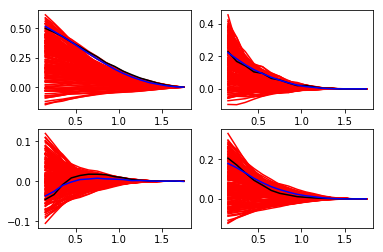

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 93 
Black==NN attempt to create BLUE from RED


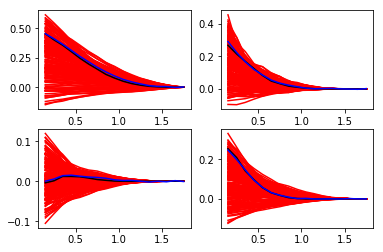

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 94 
Black==NN attempt to create BLUE from RED


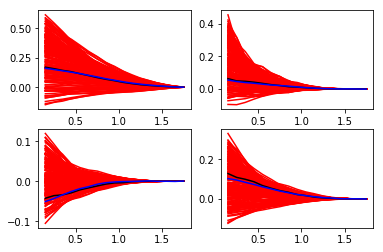

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 95 
Black==NN attempt to create BLUE from RED


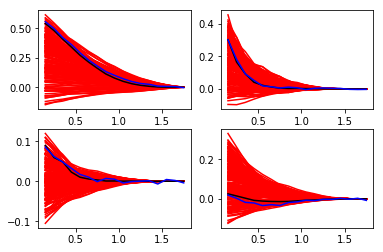

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 96 
Black==NN attempt to create BLUE from RED


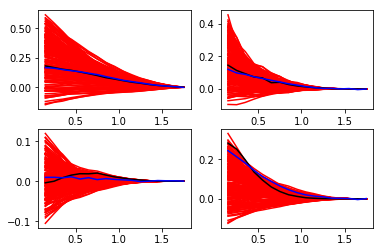

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 97 
Black==NN attempt to create BLUE from RED


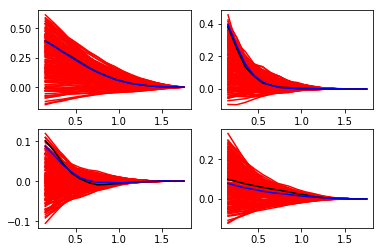

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 98 
Black==NN attempt to create BLUE from RED


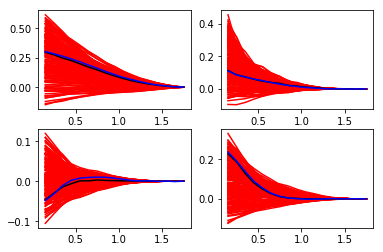

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 99 
Black==NN attempt to create BLUE from RED


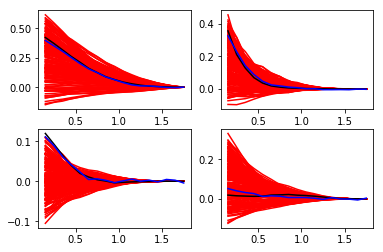

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 100 
Black==NN attempt to create BLUE from RED


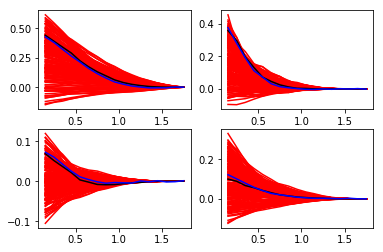

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 101 
Black==NN attempt to create BLUE from RED


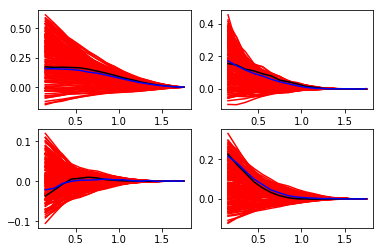

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 102 
Black==NN attempt to create BLUE from RED


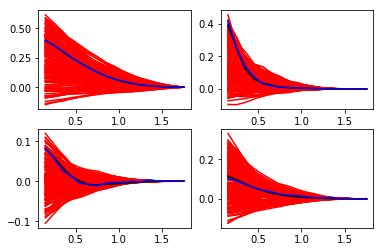

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 103 
Black==NN attempt to create BLUE from RED


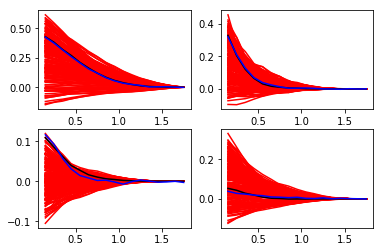

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 104 
Black==NN attempt to create BLUE from RED


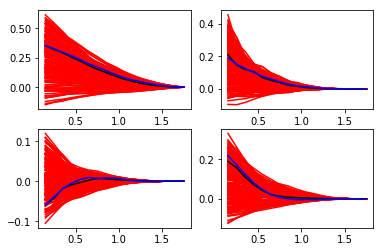

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 105 
Black==NN attempt to create BLUE from RED


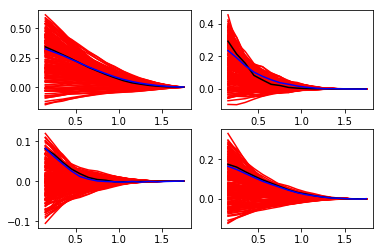

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 106 
Black==NN attempt to create BLUE from RED


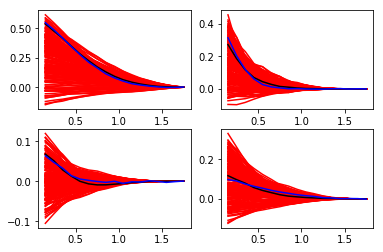

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 107 
Black==NN attempt to create BLUE from RED


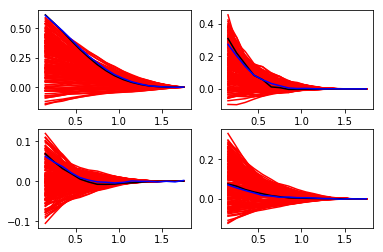

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 108 
Black==NN attempt to create BLUE from RED


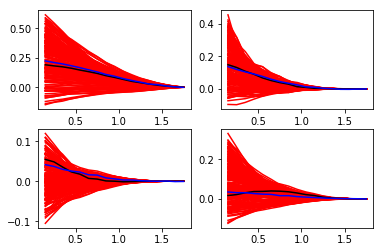

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 109 
Black==NN attempt to create BLUE from RED


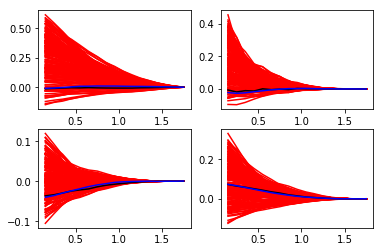

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 110 
Black==NN attempt to create BLUE from RED


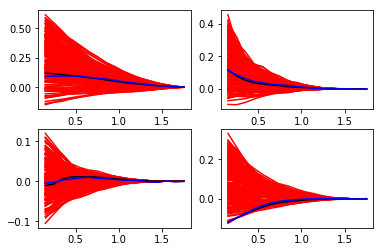

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 111 
Black==NN attempt to create BLUE from RED


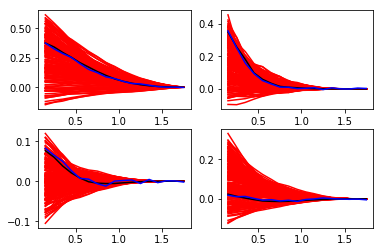

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 112 
Black==NN attempt to create BLUE from RED


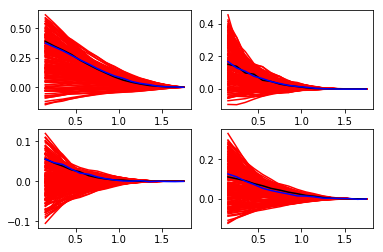

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 113 
Black==NN attempt to create BLUE from RED


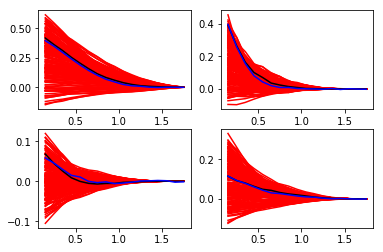

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 114 
Black==NN attempt to create BLUE from RED


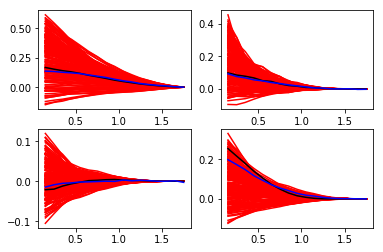

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 115 
Black==NN attempt to create BLUE from RED


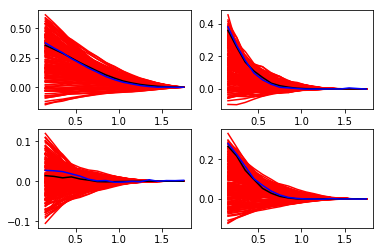

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 116 
Black==NN attempt to create BLUE from RED


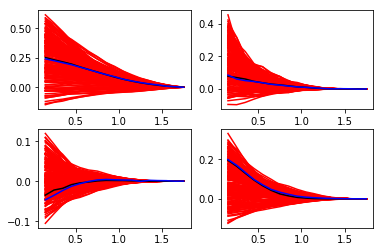

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 117 
Black==NN attempt to create BLUE from RED


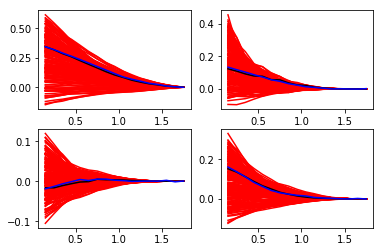

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 118 
Black==NN attempt to create BLUE from RED


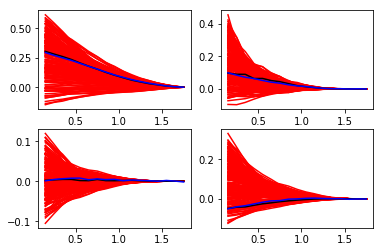

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 119 
Black==NN attempt to create BLUE from RED


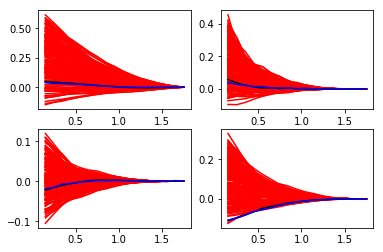

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 120 
Black==NN attempt to create BLUE from RED


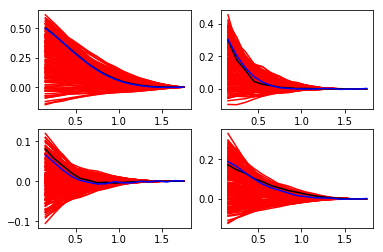

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 121 
Black==NN attempt to create BLUE from RED


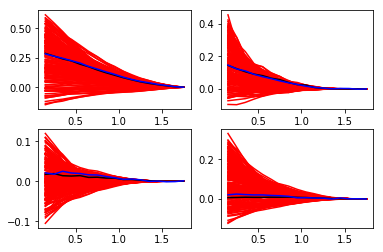

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 122 
Black==NN attempt to create BLUE from RED


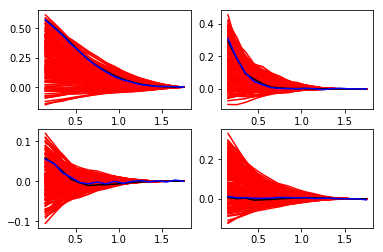

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 123 
Black==NN attempt to create BLUE from RED


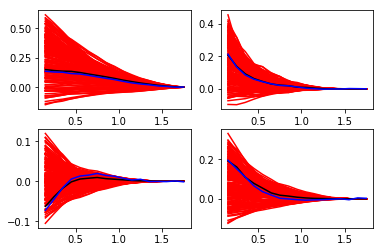

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 124 
Black==NN attempt to create BLUE from RED


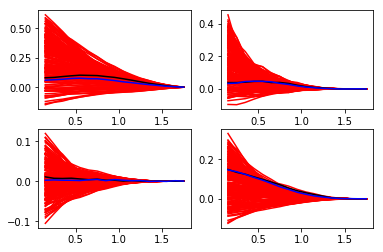

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 125 
Black==NN attempt to create BLUE from RED


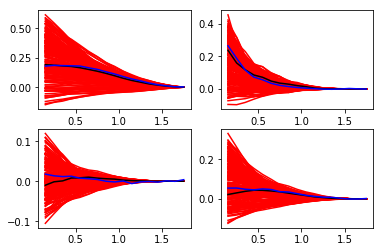

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 126 
Black==NN attempt to create BLUE from RED


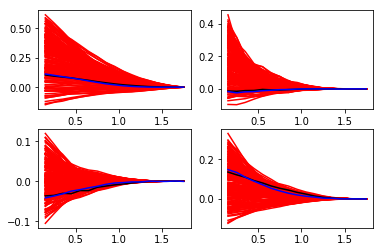

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 127 
Black==NN attempt to create BLUE from RED


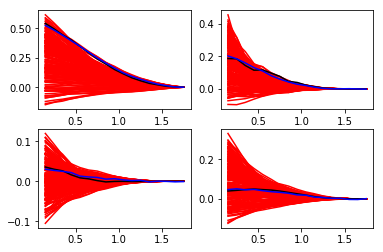

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 128 
Black==NN attempt to create BLUE from RED


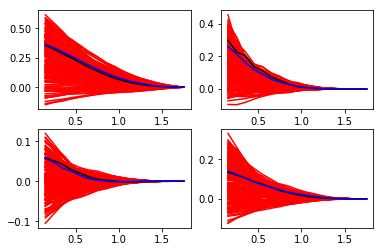

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 129 
Black==NN attempt to create BLUE from RED


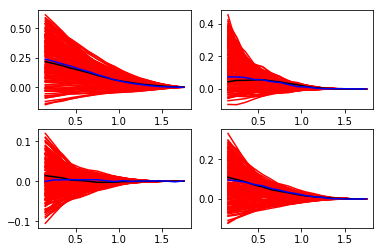

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 130 
Black==NN attempt to create BLUE from RED


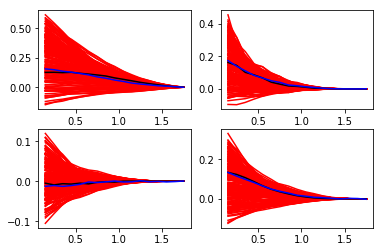

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 131 
Black==NN attempt to create BLUE from RED


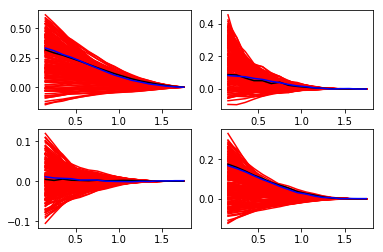

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 132 
Black==NN attempt to create BLUE from RED


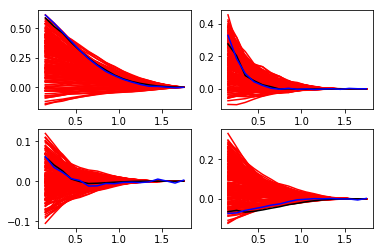

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 133 
Black==NN attempt to create BLUE from RED


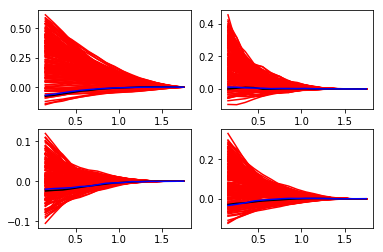

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 134 
Black==NN attempt to create BLUE from RED


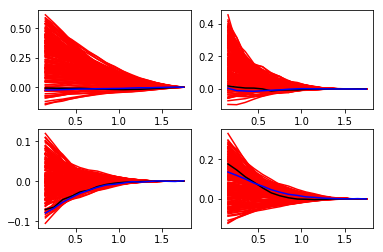

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 135 
Black==NN attempt to create BLUE from RED


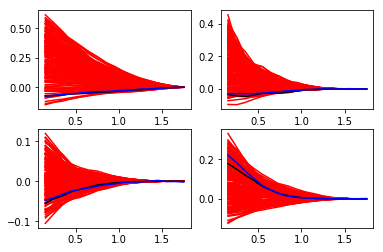

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 136 
Black==NN attempt to create BLUE from RED


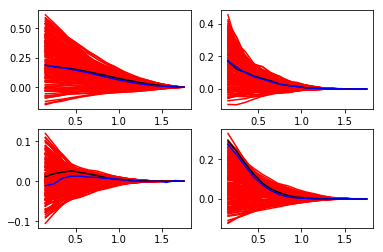

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 137 
Black==NN attempt to create BLUE from RED


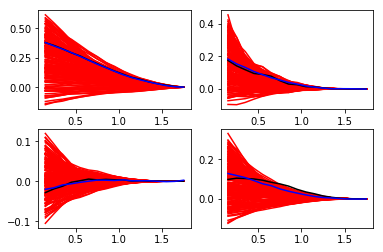

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 138 
Black==NN attempt to create BLUE from RED


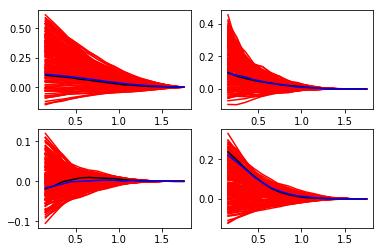

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 139 
Black==NN attempt to create BLUE from RED


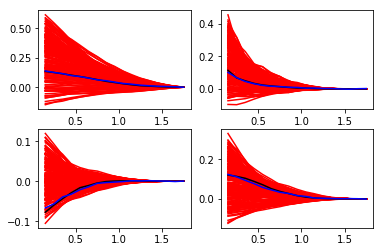

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 140 
Black==NN attempt to create BLUE from RED


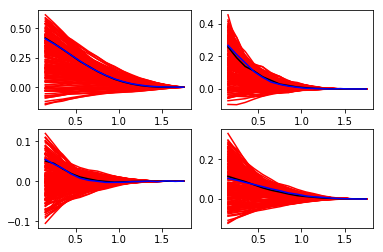

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 141 
Black==NN attempt to create BLUE from RED


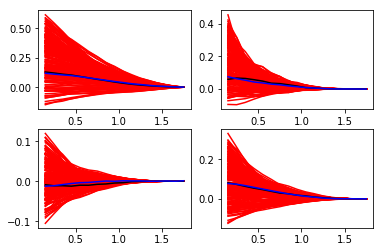

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 142 
Black==NN attempt to create BLUE from RED


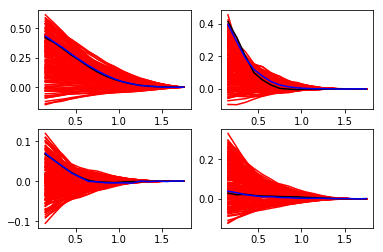

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 143 
Black==NN attempt to create BLUE from RED


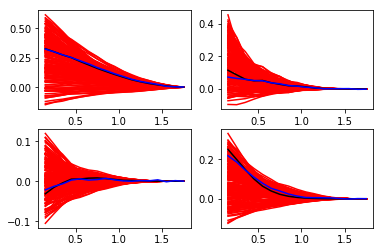

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 144 
Black==NN attempt to create BLUE from RED


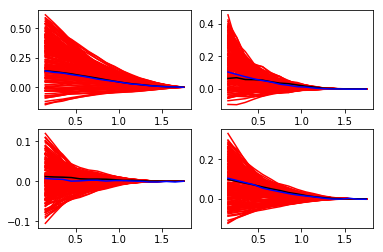

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 145 
Black==NN attempt to create BLUE from RED


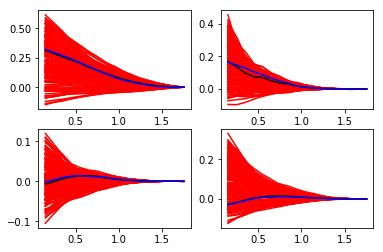

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 146 
Black==NN attempt to create BLUE from RED


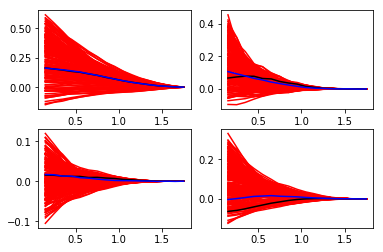

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 147 
Black==NN attempt to create BLUE from RED


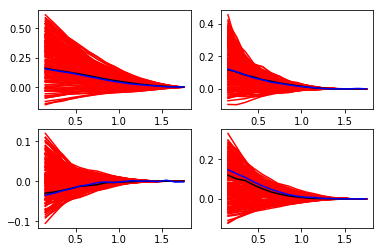

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 148 
Black==NN attempt to create BLUE from RED


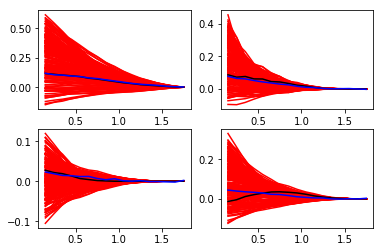

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 149 
Black==NN attempt to create BLUE from RED


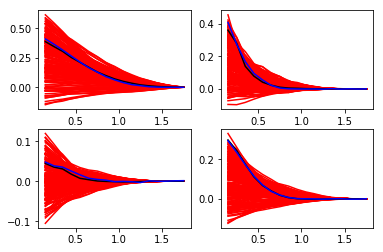

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 150 
Black==NN attempt to create BLUE from RED


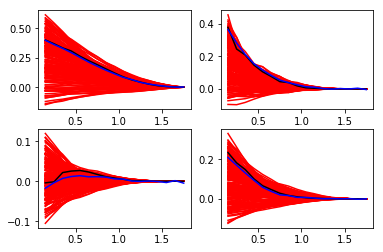

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 151 
Black==NN attempt to create BLUE from RED


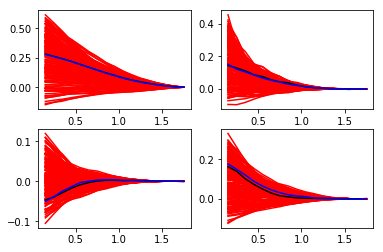

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 152 
Black==NN attempt to create BLUE from RED


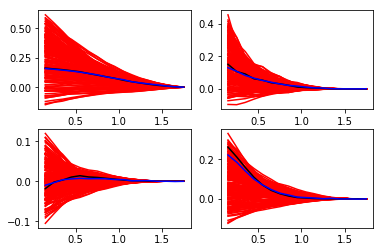

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 153 
Black==NN attempt to create BLUE from RED


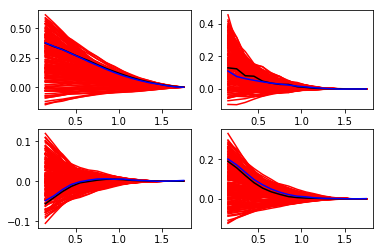

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 154 
Black==NN attempt to create BLUE from RED


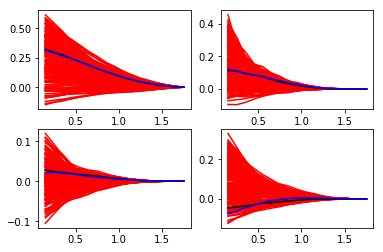

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 155 
Black==NN attempt to create BLUE from RED


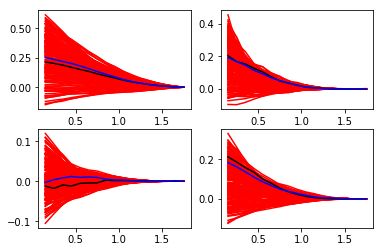

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 156 
Black==NN attempt to create BLUE from RED


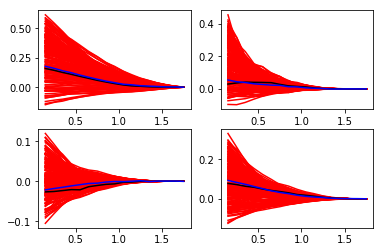

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 157 
Black==NN attempt to create BLUE from RED


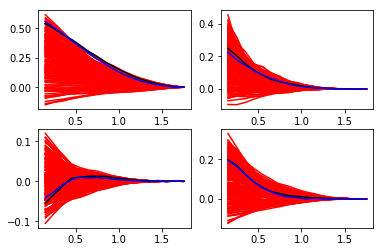

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 158 
Black==NN attempt to create BLUE from RED


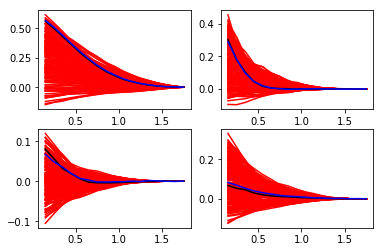

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 159 
Black==NN attempt to create BLUE from RED


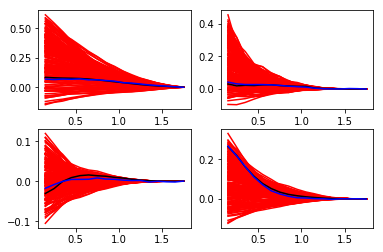

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 160 
Black==NN attempt to create BLUE from RED


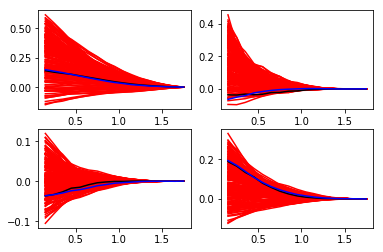

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 161 
Black==NN attempt to create BLUE from RED


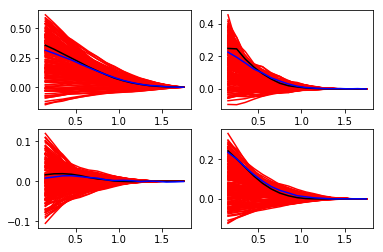

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 162 
Black==NN attempt to create BLUE from RED


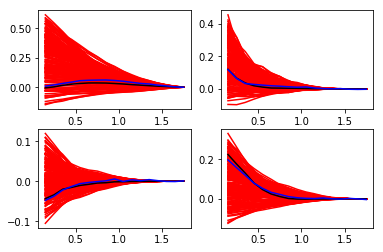

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 163 
Black==NN attempt to create BLUE from RED


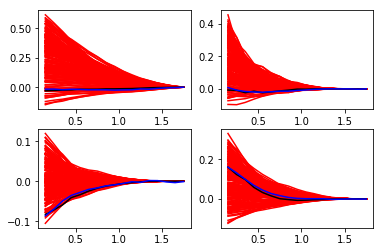

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 164 
Black==NN attempt to create BLUE from RED


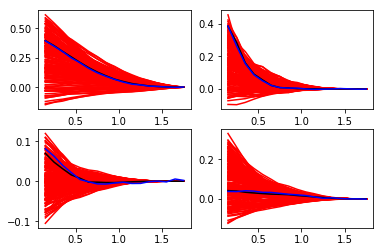

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 165 
Black==NN attempt to create BLUE from RED


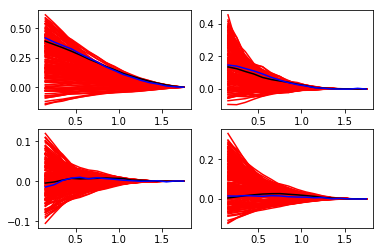

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 166 
Black==NN attempt to create BLUE from RED


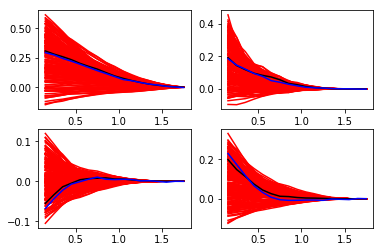

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 167 
Black==NN attempt to create BLUE from RED


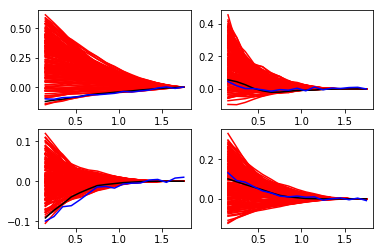

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 168 
Black==NN attempt to create BLUE from RED


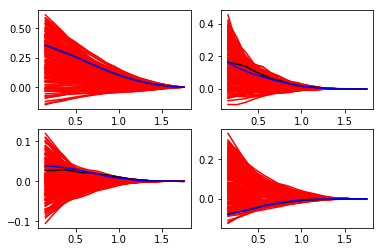

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 169 
Black==NN attempt to create BLUE from RED


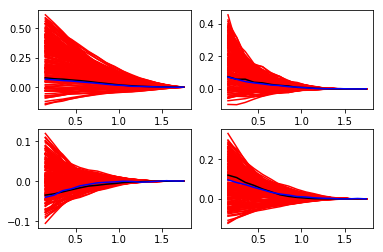

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 170 
Black==NN attempt to create BLUE from RED


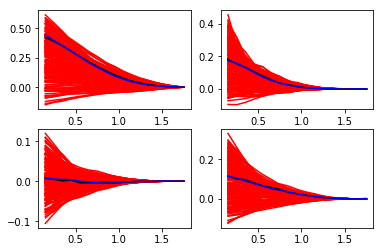

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 171 
Black==NN attempt to create BLUE from RED


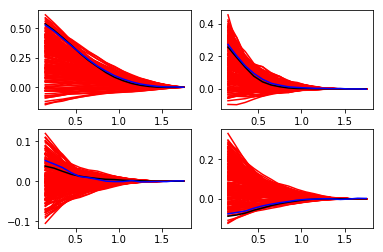

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 172 
Black==NN attempt to create BLUE from RED


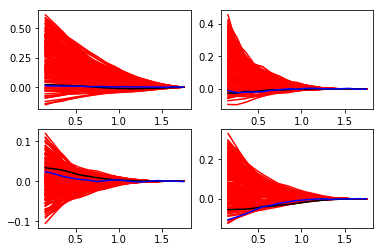

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 173 
Black==NN attempt to create BLUE from RED


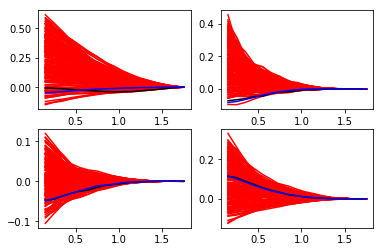

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 174 
Black==NN attempt to create BLUE from RED


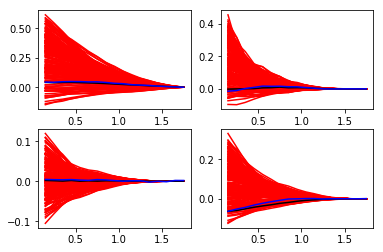

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 175 
Black==NN attempt to create BLUE from RED


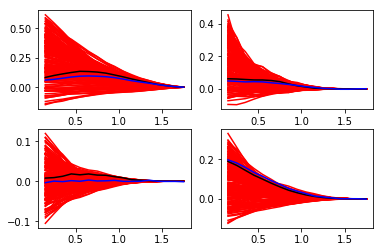

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 176 
Black==NN attempt to create BLUE from RED


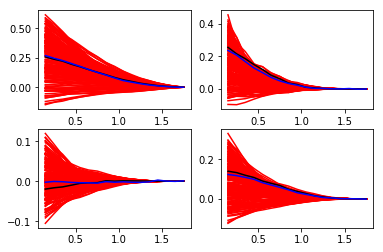

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 177 
Black==NN attempt to create BLUE from RED


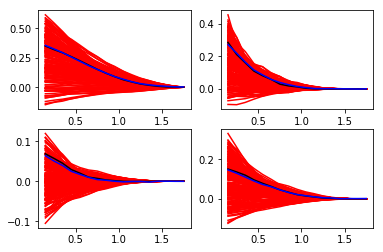

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 178 
Black==NN attempt to create BLUE from RED


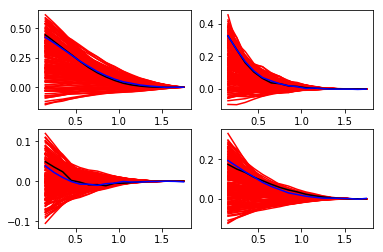

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 179 
Black==NN attempt to create BLUE from RED


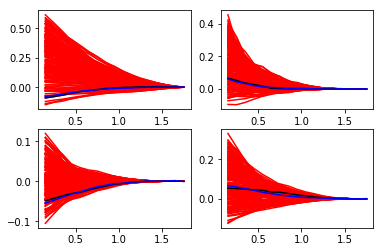

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 180 
Black==NN attempt to create BLUE from RED


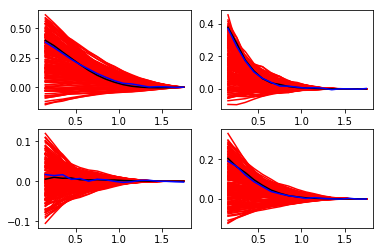

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 181 
Black==NN attempt to create BLUE from RED


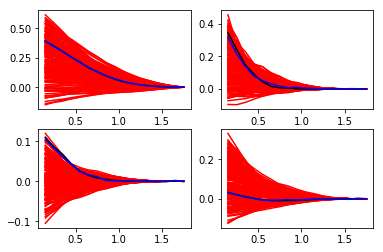

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 182 
Black==NN attempt to create BLUE from RED


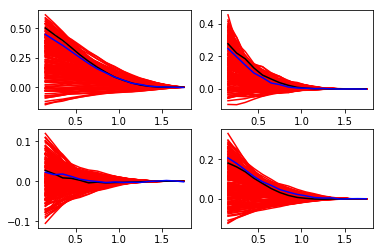

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 183 
Black==NN attempt to create BLUE from RED


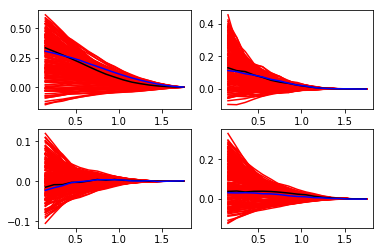

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 184 
Black==NN attempt to create BLUE from RED


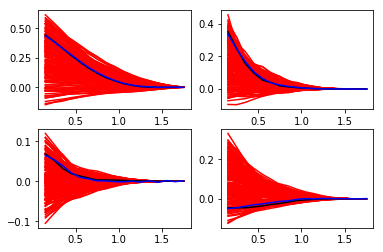

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 185 
Black==NN attempt to create BLUE from RED


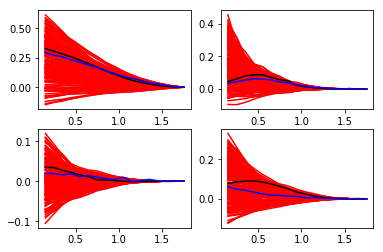

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 186 
Black==NN attempt to create BLUE from RED


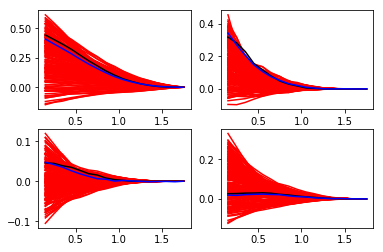

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 187 
Black==NN attempt to create BLUE from RED


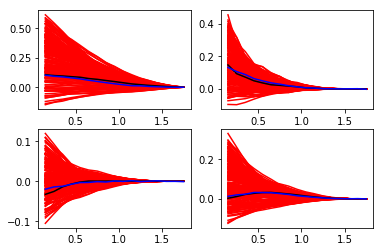

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 188 
Black==NN attempt to create BLUE from RED


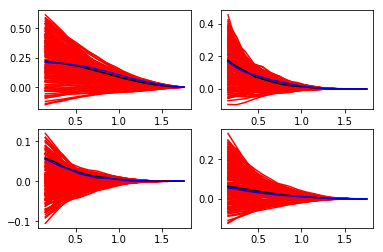

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 189 
Black==NN attempt to create BLUE from RED


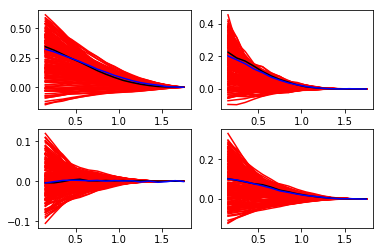

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 190 
Black==NN attempt to create BLUE from RED


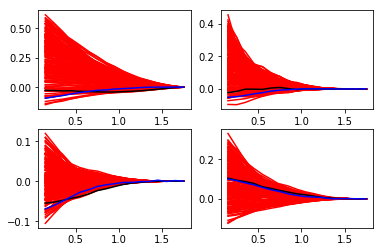

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 191 
Black==NN attempt to create BLUE from RED


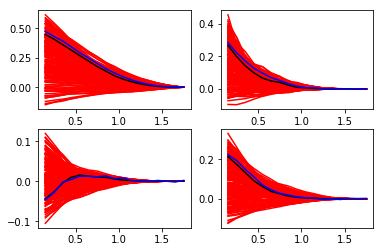

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 192 
Black==NN attempt to create BLUE from RED


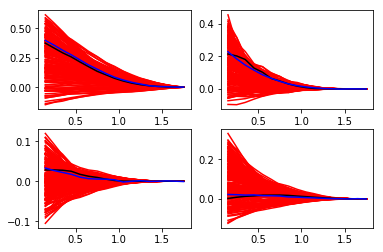

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 193 
Black==NN attempt to create BLUE from RED


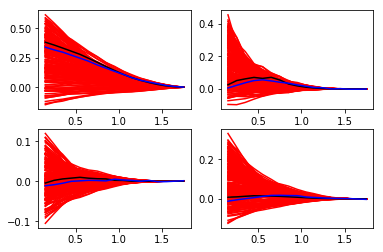

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 194 
Black==NN attempt to create BLUE from RED


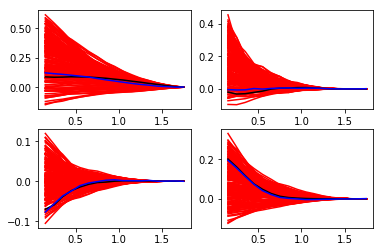

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 195 
Black==NN attempt to create BLUE from RED


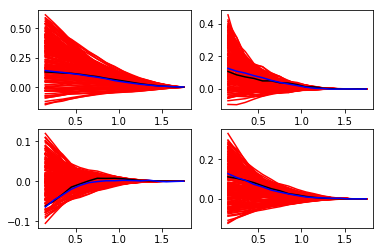

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 196 
Black==NN attempt to create BLUE from RED


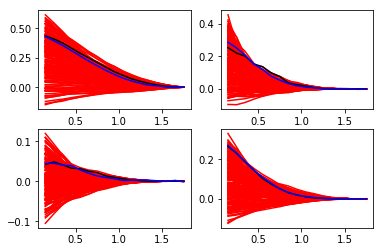

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 197 
Black==NN attempt to create BLUE from RED


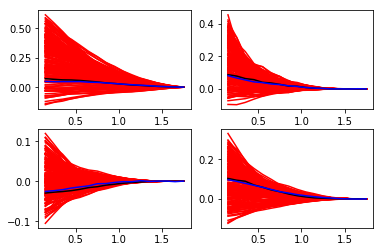

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 198 
Black==NN attempt to create BLUE from RED


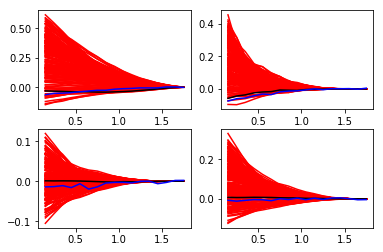

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 199 
Black==NN attempt to create BLUE from RED


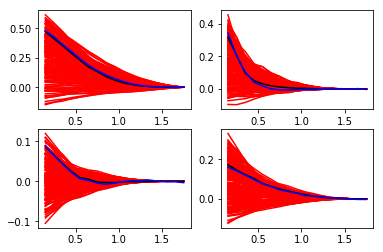

In [34]:
for i in range(200):
    ReconstructTarget(parameters,model,i)

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 125 
Black==NN attempt to create BLUE from RED


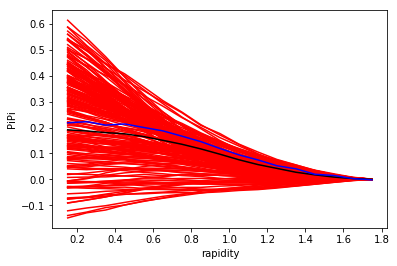

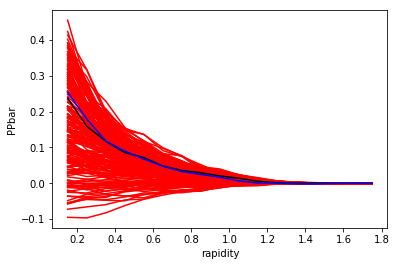

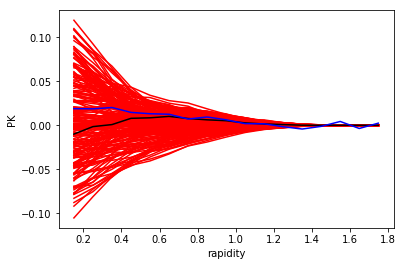

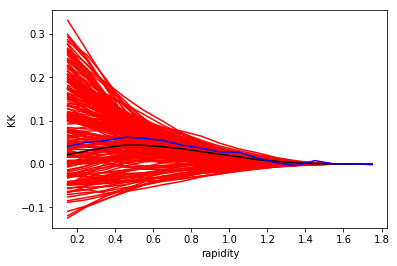

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 126 
Black==NN attempt to create BLUE from RED


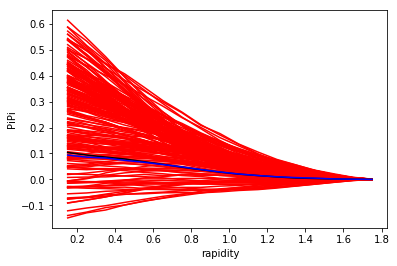

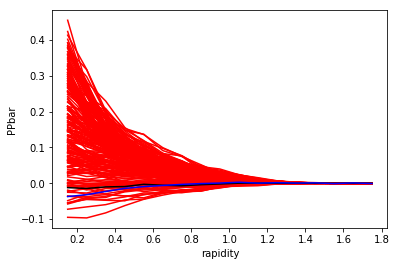

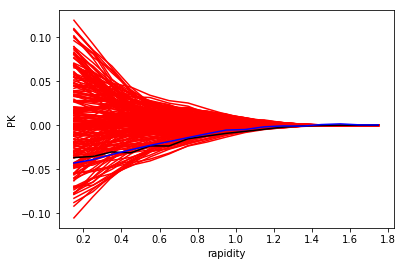

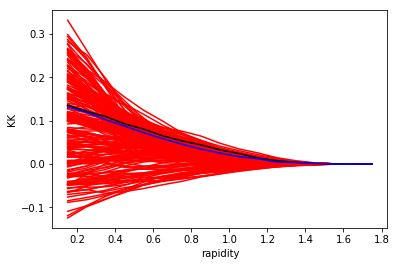

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 127 
Black==NN attempt to create BLUE from RED


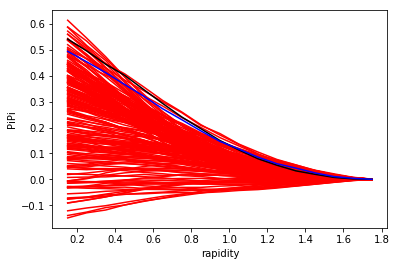

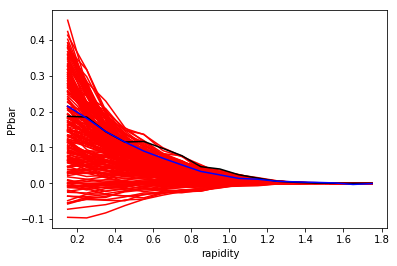

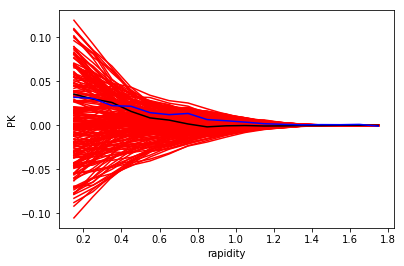

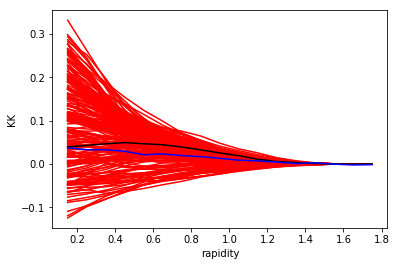

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 128 
Black==NN attempt to create BLUE from RED


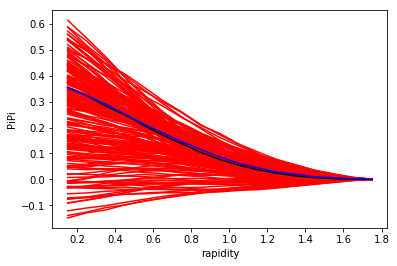

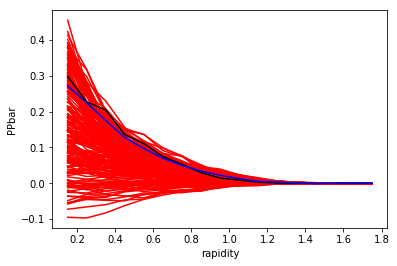

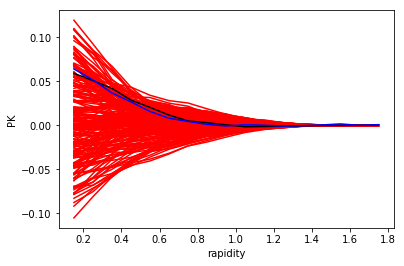

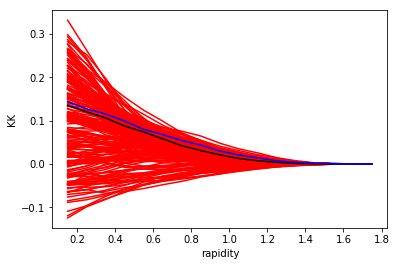

Nodes in NN layer 100
NN performance 0.0
Red==199 Model Runs
Blue== 129 
Black==NN attempt to create BLUE from RED


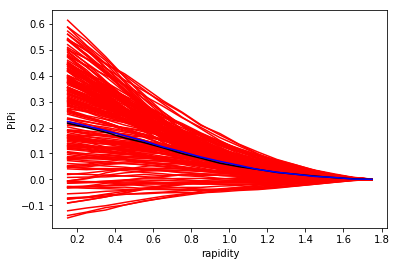

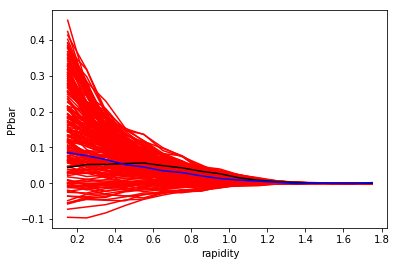

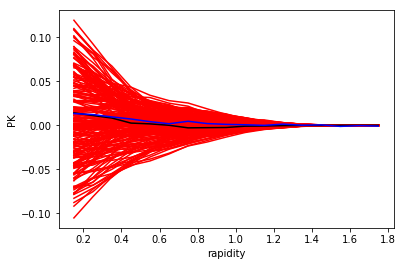

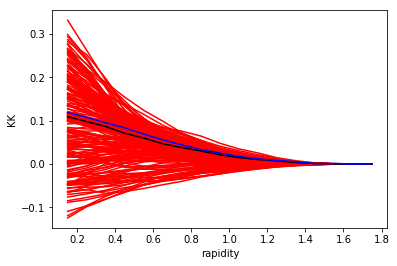

In [35]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   

def ReconstructTarget(X,y,target):
    X_train = np.append(X[:target,:],X[target+1:,:],axis=0)
    y_train = np.append(y[:target,:],y[target+1:,:],axis=0)

    X_test = X[target,:].reshape(1,-1)
    y_test = y[target,:].reshape(1,-1)

    xscale=1.0
    X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)

    layer=100
    print("Nodes in NN layer",layer)
    NN = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \
                  #random_sate=1, \
                 )

    NN.fit(X_train_norm,y_train)
    y_pred = NN.predict(X_test_norm)
    perf = NN.score(X_test_norm,y_test)

    print("NN performance",perf)

    print("Red==199 Model Runs\nBlue==",target,"\nBlack==NN attempt to create BLUE from RED")

    figfolder = "figs"
    fig, ax = plt.subplots()
    plt.ylabel('PiPi')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,:17].T,'red')
    plt.plot(dy,y_test[:,:17].T,'black')
    plt.plot(dy,y_pred[:,:17].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/pipi_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('PPbar')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,17:34].T,'red')
    plt.plot(dy,y_test[:,17:34].T,'black')
    plt.plot(dy,y_pred[:,17:34].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/ppbar_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('PK')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,34:51].T,'red')
    plt.plot(dy,y_test[:,34:51].T,'black')
    plt.plot(dy,y_pred[:,34:51].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/pk_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('KK')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,51:68].T,'red')
    plt.plot(dy,y_test[:,51:68].T,'black')
    plt.plot(dy,y_pred[:,51:68].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/kk_nn.pdf")

target = 125
for i in range(target,target+5):
    ReconstructTarget(parameters,model,i)

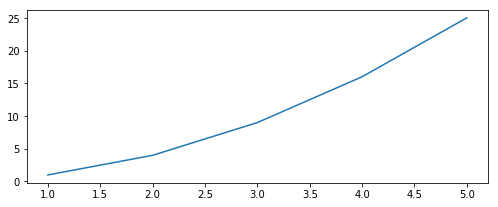

In [ ]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt   

def ReconstructTarget(X,y,target):
    X_train = np.append(X[:target,:],X[target+1:,:],axis=0)
    y_train = np.append(y[:target,:],y[target+1:,:],axis=0)

    X_test = X[target,:].reshape(1,-1)
    y_test = y[target,:].reshape(1,-1)

    xscale=1.0
    X_train_norm, X_test_norm, xmaxv, xminv = NormFeatures(X_train,X_test,xscale)

    layer=100
    print("Nodes in NN layer",layer)
    NN = MLPRegressor(hidden_layer_sizes=(layer), \
                  max_iter=500,
                  solver='lbfgs', \
                  alpha=1e-4, \
                  learning_rate_init=1e-3, \
                  activation='relu', \
                  #random_sate=1, \
                 )

    NN.fit(X_train_norm,y_train)
    y_pred = NN.predict(X_test_norm)
    perf = NN.score(X_test_norm,y_test)

    print("NN performance",perf)

    print("Red==199 Model Runs\nBlue==",target,"\nBlack==NN attempt to create BLUE from RED")

    figfolder = "figs"
    fig, ax = plt.subplots()
    plt.ylabel('PiPi')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,:17].T,'red')
    plt.plot(dy,y_test[:,:17].T,'black')
    plt.plot(dy,y_pred[:,:17].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/pipi_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('PPbar')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,17:34].T,'red')
    plt.plot(dy,y_test[:,17:34].T,'black')
    plt.plot(dy,y_pred[:,17:34].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/ppbar_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('PK')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,34:51].T,'red')
    plt.plot(dy,y_test[:,34:51].T,'black')
    plt.plot(dy,y_pred[:,34:51].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/pk_nn.pdf")

    fig, ax = plt.subplots()
    plt.ylabel('KK')
    plt.xlabel('rapidity')
    plt.plot(dy,y_train[:,51:68].T,'red')
    plt.plot(dy,y_test[:,51:68].T,'black')
    plt.plot(dy,y_pred[:,51:68].T,'blue')
    plt.show()
    fig.savefig(figfolder+"/kk_nn.pdf")

target = 125
for i in range(target,target+5):
    ReconstructTarget(parameters,model,i)